# Data Science Coursework 2
## Task 1: Neural networks
In Task 1, we will explore how two different neural network architectures perform on a supervised classification
task on the CIFAR-10 dataset of images. This dataset contains 50,000 training and 10,000 validation images
belonging to 10 classes, e.g., airplanes, birds, cars, ships, etc The CIFAR-10 dataset is well balanced, i.e., it has
5,000 images of each class in the training set and 1,000 images of each class in the validation set.

We begin by importing packages and loading the data needed for this task.

In [1]:
# load required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# downloading the data
def load_data():
    (x_train, y_train), (x_val, y_val) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 255
    x_val = x_val.astype('float32') / 255
    
    # convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
    return ((x_train, y_train), (x_val, y_val))

170500096/170498071 [==============================] - 4s 0us/step


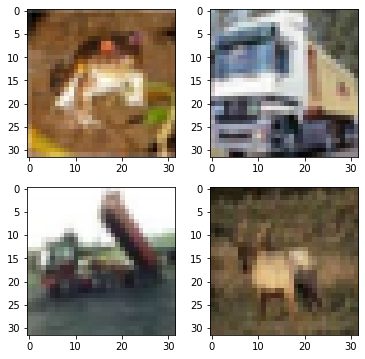

In [4]:
(x_train, y_train), (x_val, y_val) = load_data()

# see what some of the images in the data look like
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(x_train[i],cmap='gray');

Before starting, we must flatten the data to be able to process it.

In [5]:
# flatten the data
x_train = x_train.reshape([x_train.shape[0], -1])
x_val = x_val.reshape([x_val.shape[0], -1])
print(x_train.shape)

(50000, 3072)


### 1.1 Multi-layer perceptron
### 1.1.1 MLP using Numpy

The multi-layer perceptron, also known as a feed-forward network, is one of the simplest type of deep learning models. It composes multiple affine transformations together, and applies a pointwise nonlinearity in between. 

$$
\begin{align}
\boldsymbol{h}^{(0)} &:= \boldsymbol{x},\\
\boldsymbol{h}^{(k)} &= \sigma\left((\boldsymbol{h}^{(k-1)})^T \boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)} \right),\qquad k=1,\ldots, L,\\
\hat{\boldsymbol{y}} &= \sigma_{out}\left((\boldsymbol{h}^{(L)})^T \boldsymbol{W}^{(L)} + \boldsymbol{b}^{(L)} \right),
\end{align}
$$

where $\boldsymbol x\in\mathbb{R}^D$, $\hat{\boldsymbol{y}}\in\mathbb{R}^{n_{L+1}}$, $L$ is the number of hidden layers in the model, $\boldsymbol{W}^{(k)}\in\mathbb{R}^{n_{k}\times n_{k+1}}$, $\boldsymbol{b}^{(k)}\in\mathbb{R}^{n_{k+1}}$, $\boldsymbol{h}^{(k)}\in\mathbb{R}^{n_k}$, $\sigma, \sigma_{out}: \mathbb{R}\mapsto\mathbb{R}$ are activation functions that operate element-wise, $n_k$ is the number of units in the $k$-th hidden layer, and we have set $n_0 := D$.

We define the architecture of the network as follows.
**Architecture of the network:** 
- Five hidden layers, each with 400 neurons, followed by the output layer with 10 neurons. 
- Use the standardised tanh(x) function as the activation function between all layers, and the softmax function as the activation function on the output layer.
- Fix the optimisation method to be stochastic gradient descent (SGD), and define the loss function as cross-entropy.

We will train the MLP on batches of 128 data points with a learning rate of 0.01 for 40 epochs. For both the
training and validation sets, we will plot the loss function and the accuracy of this model as a function of the
number of epochs and discuss the convergence of the model.

We begin with the feed-forward step and then move onto the back-propagation step. The feed-forwards step involves calculating the weights, bias, activations and post-activations whereas back propagation solve an optimization problem where we look for the minimum of a function.

**Feed-forward**

We first implement a simple Dense layer as they will construct our 5 hidden layers.

In [6]:
# this function implements the dense layer transformation to obtain the pre-activation values
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W 
    return h

The output layer of our model will use a softmax activation function that we implement in the cell below.

In [7]:
# softmax function
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{3072\times 400}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{400}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{400\times 400}$, $k=1, 2, 3, 4$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{400}$, $k=1, 2, 3, 4$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(5)} \in\mathbb{R}^{400\times 10}$
* Bias $\boldsymbol{b}^{(5)} \in\mathbb{R}^{10}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively.

This MLP model has six kernel variables and six bias variables. We initialize weights as random values.

In [8]:
# Create the parameters
var0 = 2. / (400 + 10)
W0 = np.random.randn(3072, 400) * np.sqrt(var0) #(3072, 400)
b0 = np.zeros(400) # (400,)

var1 = 2. / (400 + 400)
W1 = np.random.randn(400, 400) * np.sqrt(var1)
b1 = np.zeros(400)  #(400, 400)

var2 = 2. / (400 + 400)
W2 = np.random.randn(400, 400) * np.sqrt(var2)
b2 = np.zeros(400)

var3 = 2. / (400 + 400)
W3 = np.random.randn(400, 400) * np.sqrt(var3) #(400, 400)
b3 = np.zeros(400) # (400,)

var4 = 2. / (400 + 400)
W4 = np.random.randn(400, 400) * np.sqrt(var4) #(400, 400)
b4 = np.zeros(400)

var5 = 2. / (10 + 400)
W5 = np.random.randn(400, 10) * np.sqrt(var4) #(400, 10)
b5 = np.zeros(10) # (10,)

weights = [W0, W1, W2, W3, W4, W5]
bias = [b0, b1, b2, b3, b4, b5]

We use these parameters and the `dense` function to create the MLP model. The hidden layers of the model has a standardised tanh(x) activation, and the output of the model has a softmax activation function.

In [10]:
def mlp(x):
    
    # input: x (50000 x 10 array of inputs)
    # returns: y_hat (50000 x 10 output array), activations and post_activations

    a1 = dense(x, W0, b0) # activation function for hidden layer 1  (50000, 400)
    h1 = np.tanh(a1) # (50000, 400)
    
    a2 = dense(h1, W1, b1) # activation function for hidden layer 2
    h2 = np.tanh(a2)
        
    a3 = dense(h2, W2, b2) # activation function for hidden layer 3
    h3 = np.tanh(a3)
        
    a4 = dense(h3, W3, b3) # activation function for hidden layer 4
    h4 = np.tanh(a4) 
        
    a5 = dense(h4, W4, b4) # activation function forhidden  layer 5 # (50000, 400)
    h5 = np.tanh(a5) # (50000, 400)
        
    a6 = dense(h5, W5, b5) # activation function for output layer (50000, 10)
    y_hat = softmax(a6) # (50000, 10)
    
    activations = [a1, a2, a3, a4, a5, a6]
    post_activations = [h1, h2, h3, h4, h5]
            
    return y_hat, activations, post_activations

In [11]:
# Get output of the initialised model
y_hat, activations, post_activations = mlp(x_train)

**Back-propagation**

We can now move onto the backpropagation algorithm which can be summarised as follows:

>1. Define the **error** $\delta^{(k)}_p := \frac{\partial \mathcal{L}_i}{\partial a^{(k)}_p}$ for layer $k$, where we denote $\mathcal{L}_i$ as the loss for example $i$, and $a^{(k)}_p$ is the $p$-th pre-activation in layer $k$
>2. Propagate the signal forwards by passing an input vector $x_i$ through the network and computing all pre-activations and post-activations using $\mathbf{a}^{(k)} = (\boldsymbol{h}^{(k-1)})^T\boldsymbol{W}^{(k-1)} + \boldsymbol{b}^{(k-1)}$
> 3. Evaluate $\boldsymbol{\delta}^{(L+1)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(L+1)}}$ for the output neurons
> 4. Backpropagate the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}$
> 5. Obtain the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$

In the above, $\boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})$ is a diagonal matrix with diagonal elements $\sigma'(a^{(k)}_p)$, $p=1,\ldots,n_k$, where $n_k$ is the number of neurons in hidden layer $k$.

In our case, we have an MLP with five hidden layers ($L=5$). The loss that we wish to minimise is the cross-entropy loss:
$$
L = H(y,\hat{y}) = -\sum_i^cy_ilog(\hat{y}_i)
$$

where $y$ is the input data, $\hat{y}$ is the vector of predicted outputs and $c$ is the number of classes (here $10$).

We use the softmax function as our activation function. The softmax function takes as inputs a vector $\bf{z}$
and is given by:
$$
y_C = \sigma(\bf{z}_C) = \frac{e^{z_C}}{\sum_{d=1}^{10}e^{z_d}}
$$ for $C = 1, ..., 10$ in our case.

We will need the derivative for the softmax function later therefore I derive it here:
if $i=j$,
$$
\frac{\partial {y_i}}{\partial {z_j}} = \frac{\partial {\frac{e^z_C}{\sum_C}}}{\partial {z_j}} = \frac{e^z_C\sum_C-e^z_ie^z_i}{\sum_C^2} = \frac{e^z_i}{\sum_C}\bigg(1-\frac{e^z_i}{\sum_C}\bigg) = y_i(1-y_i)
$$
but if $i\neq j$,
$$
\frac{\partial {y_i}}{\partial {z_j}} = \frac{\partial {\frac{e^z_C}{\sum_C}}}{\partial {z_j}} = \frac{0-e^z_ie^z_j}{\sum_C^2} = -\frac{e^z_i}{\sum_C}\frac{e^z_j}{\sum_C} = -y_iy_j
$$

To evaluate the error for the output neurons (step $3$ in the algorithm above), we will need the derivative of $L$ with respect to the activations. The derivation of the derivative is as follows (6):
$$
\frac{\partial L}{\partial a_i} = -\sum_{k=1}^{10}y_k \frac{\partial log(\hat{y}_k)}{\partial a_i} = -\sum_{k=1}^{10}y_k \frac{\partial log(\hat{y}_k)}{\partial \hat{y}_k} \frac{\partial \hat{y}_k}{\partial a_i} = -\sum_{k=1}^{10}y_k \frac{1}{\hat{y}_k} \frac{\partial \hat{y}_k}{\partial a_i}
$$
Where $a_i$ is the activation function.
Now, from the derivative of the softmax function that we derived earlier, we can write:
$$
\frac{\partial L}{\partial a_i} = -y_i (1-\hat{y}_i) + \sum_{k\neq i} y_k \hat{y}_i = -y_i + y_i \hat{y}_i + \sum_{k\neq i} y_k \hat{y}_k  = \hat{y}_i\bigg(y_i + \sum_{k\neq i}y_k \bigg) - y_i
$$
Because $y$ is a one hot encoded vector, we know $\sum_{k=1}^{10}y_k=1$ and $y_i + \sum_{k\neq i}y_k = 1$.
We therefore have:
$$
\frac{\partial L}{\partial a_i} = \hat{y}_i - y_i
$$

We will start by computing the output error $\boldsymbol{\delta}^{(6)} = \frac{\partial \mathcal{L}_i}{\partial \boldsymbol{a}^{(6)}}$.

In [12]:
# error of the output later with the softmax activation function
def output_error(y_hat, y_batch):
    
    # y_hat: 500000 x 10 array of output pre-activations
    # y_batch: 50000 x 10 array of data outputs
    # returns: 50000 x 10 array of output errors 
    
    return np.subtract(y_hat, y_batch)

We will also need to compute the diagonal matrix $\boldsymbol{\sigma}'(\boldsymbol{a}^{(L)})$:

In [14]:
def tanh_derivative(a):
    
    # a1: K x 400 array of hidden layer pre-activations
    # returns: K x 400 array of diagonal elements  
    
    return 1 - np.square(np.tanh(a))

Given the output error $\boldsymbol{\delta}^{(6)}$, kernel matrix $\boldsymbol{W}^{(5)}$ and the preactivations $\boldsymbol a^{(5)}$, we need to backpropagate the error $\boldsymbol{\delta}^{(6)}$ to get $\boldsymbol{\delta}^{(5)}$, then $\boldsymbol{\delta}^{(5)}$ to get $\boldsymbol{\delta}^{(4)}$, etc.

Stochastic gradient descent samples a batch of $K$ input and output samples, and makes a parameter update by  computing the gradient 

$$
\nabla_{(\boldsymbol{b}, \boldsymbol{W})}\mathcal{L}(\boldsymbol{b}, \boldsymbol{W}) \mid \mathcal{X}^{(i)}, \mathcal{Y}^{(i)}),
$$

where $\boldsymbol{b}, \boldsymbol{W}$ are the values of the parameters at the $i$-th iteration of the algorithm, and $\mathcal{X}^{(i)}, \mathcal{Y}^{(i)}$ are the $i$-th batch of inputs and outputs.

The following function should compute this gradient for a given batch of data, and current parameter values.



In [15]:
def grads(x_train, y_train):
    y_hat, activations, post_activations = mlp(x_train)
    delta = output_error(y_hat, y_train)

    # empty lists to store gradients
    b_grads = [None] * 6 
    W_grads = [None] * 6
   
    b_grads[5] = np.mean(delta, axis=0)
    W_grads[5] = np.transpose(delta) @ post_activations[4] / 128

    for i in range(4, -1, -1):
      delta = delta @ np.transpose(weights[i+1]) 
      delta = tanh_derivative(activations[i]) * delta
      b_grads[k] = np.mean(delta, axis=0) / 128
      W_grads[k] = np.transpose(delta) @ post_activations[k] / 128
    return b_grads, W_grads

To create my batches, I first randomly permutated the data, then read off the first 128 indeces of x_train to form the first x_batch, then the next 128 indeces as the next batch. I did the same to get the batches of y_train.

In [23]:
def get_batches(x_train, y_train):
    
    x_batches = [] # empty list to store batches
    y_batches = [] # empty list to store batches
    batch_size = 128
    num_batches = len(x_train) // batch_size
    x_train = np.random.permutation(x_train) # shuffling the data
    y_train = np.random.permutation(y_train) # shuffling the data
    
    for i in range(num_batches+1):
        start = i * batch_size  # standard case
        end = start + batch_size
        batch_indices_x = x_train[start:end]
        batch_indices_y = y_train[start:end]
        x_batches.append(batch_indices_x)
        y_batches.append(batch_indices_y)
    return x_batches, y_batches

Lastly, we create a function that will compute the cross entropy loss.

In [78]:
from math import log2
def cross_entropy_loss(y_hat, y_train):
  for i in range(128):
    for j in range(10):
      yh = y_hat[i,j]
      yt = y_train[i,j]
      loss = yh * log2(yt)
  return loss

We are now ready to run the full training loop.

In [79]:
# Run the training loop

epochs = 40
learning_rate = 0.01
losses = []
x_batches, y_batches = get_batches(x_train, y_train)

for epoch in range(epochs):
    for x_batch in x_batches: 
      for y_batch in y_batches:
        y_hat, activations, post_activations = mlp(x_batch)
        losses.append(cross_entropy_loss(y_hat, y_batch))
        b_grads, W_grads = grads(x_batch, y_batch)
        b_gradients -= learning_rate * b_grads
        W_gradients -= learning_rate * W_grads

ValueError: ignored

In [ ]:
# Plot the learning curve
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.title("Training loss vs Epoch with learning rate=0.01")

#### 1.1.2

For this task I would expect the model with a learning rate of 0.0001 to converge the slowest and 0.1 to converge the fastest.

#### 1.1.3
In this task, we use 80 epochs. This allows us to use a smaller learning rate and hence get better results. This is because with a smaller learning rate, you take smaller steps to reach the optimal solution hence you are less likely to jump over the optimal solution. 

### 1.2 Convolutional neural network (CNN)
### 1.2.1 Implementing a CNN
Using TensorFlow, we implement a CNN according to the following architecture:
- Four hidden layers in total, first three are convolutional layers and the last is a fully-connected layer. 
- All convolutional layers apply 3 ✕ 3 feature maps, but the first uses 32 and the last two use 64 feature maps. 
- Between the convolutional layers there are 2 ✕ 2 maximum pooling layers.
- The fully-connected layer has 64 neurons and is followed by an output layer with 10 neurons. 
- You should use ReLU as your activation function between all layers, and the softmax function as the activation function on the output layer. 

We begin by importing required libraries for this task.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

(x_train, y_train), (x_val, y_val) = load_data()

170500096/170498071 [==============================] - 6s 0us/step


I do not rescale the data as it appears to already be between the interval $[0,1]$. I use the Conv2D and MaxPool2D functions as we are dealing with a 2-dimensional dataset (images). I define the input shape to be (32, 32, 3) because the images are 32x32 pixels and have a colour scale (that corresponds to 3 colours - red, blue, yellow). We define the model below according to the required achitecture:

In [29]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # conv layer 1
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'), # conv layer 2
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'), # conv layer 3
    Flatten(),
    Dense(64, activation='relu'),   # fully connected layer
    Dense(10, activation='softmax') # output layer
    ])

We fix the optimisation method to be stochastic gradient descent (SGD), and use the categorical cross-entropy as the loss function because of the one hot encoding of the y. 


In [30]:
# compile the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.1) # optimizer

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [6]:
# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

We now train this model on batches of 128 data points with a learning rate of 0.1 for 40 epochs. I also add the validation data to the fit so that we can later evaluate whether there was overfitting or underfitting.

In [7]:
history = model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), validation_batch_size=128, verbose=0)

We now plot the loss function and the accuracy of this model as a function of the number of epochs.


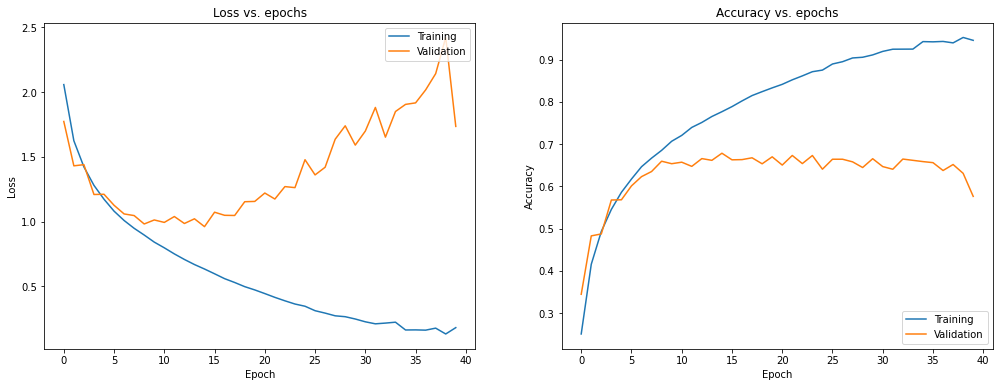

In [8]:
fig = plt.figure(figsize=(17, 6))
# loss against number of epochs
fig.add_subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
# accuracy against number of epochs
fig.add_subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

From the graphs above, there appears to be severe overfitting as the number of epochs increases: on the "Loss vs. epochs" plot, the validation loss is going very high while the training loss continues to go down and on the "Accuracy vs. Epoch" plot, the training accuracy is greater than the validation accuracy. This gap is called the generalisation gap. If there was no overfitting or underfitting, we would expect the validation loss to closely follow the training loss curve, hence having a small generalisation gap. This is why we will use regularisation methods in the next section to see whether we can reduce the overfitting. 

With regards to convergence, I look at how quickly the loss and accuracy curves flatten out. In this case, converge is not a good indicator of how well the model is performing because whilst the training loss decreases, the validation loss increases. With a learning rate of 0.1 (which is quite high compared of other learning rates like 0.001, 0.005 etc), this model perhaps doesn't converge well because we miss the optimal solutions as we are taking too large "steps".

### 1.2.2 Adding L2 regularisation in the CNN model

Models in deep learning are often very large with lots and lots of parameters therefore they often face the issue of overfitting. There exists many reguralisers that deal with overfitting and we will explore these in the next few tasks. We begin by incorporating an L2 regularisation with a coefficient of $5$x$10^{-3}$ in all convolutional layers and compare the loss and accuracy to the model we defined in the task above (task 1.2.1).

L2 regularisation is a weight reguralisation technique, it adds a penalty term to the loss function to regularise the model. The penalty terms stop the weights from growing too large where they would constrain the capacity of the model so that in does not become too complex. It is possible to add regularisation terms for the bias term aswell but here we will only be regularising the weights. L2 reguralsation can be described as follows:
$$
J(w, b)=\frac{1}{m}\sum_{i=1}^mL(\hat{y}^{(i)}, y^{(i)})+\frac{\lambda}{2m}||w||^2
$$
where $w$ is the weights, $b$ is the bias terms, $L$ is the cost function of the network and $\frac{\lambda}{2m}||w||^2$ is the added reguralisation term. As we can see from this function, the larger $\lambda$ is, the more the weights are penalised (they would have values close to zero). The activations would therefore reduce and the effect of forward propagation would decrease (1). 

In [9]:
# import required package
from tensorflow.keras import regularizers

# L2 regularisation coefficient
l2_coeff = 5e-3

In [11]:
# define and compile model 
def get_regularized_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_coeff), input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_coeff)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_coeff)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

l2_regularised_model = get_regularized_model()

In [13]:
# get model summary
l2_regularised_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [14]:
# train the model
history_1 = l2_regularised_model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), validation_batch_size=128, verbose=False) 

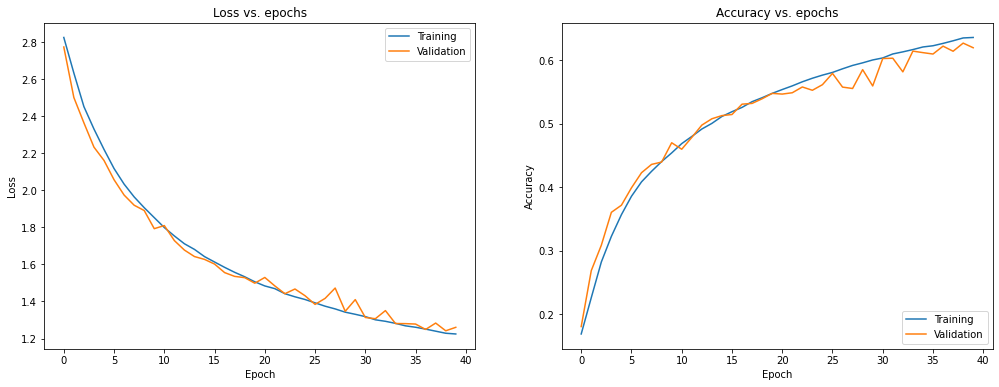

In [15]:
fig = plt.figure(figsize=(17, 6))
# loss against number of epochs
fig.add_subplot(121)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
# accuracy against number of epochs
fig.add_subplot(122)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

As we can see from the graphs, L2 regularization has practically removed the overfitting. Although the validation loss is still slightly higher than the training loss, and the validation accuracy is still slightly below the training accurary, the generalisation gap has drastically decreased. Another observation we can make is that the validation curves on both graphs are much more wavy compared to the smooth training curves. Compared to the previous model with no regularizers, the training curves reaches higher loss values and lower accuracy values which would initially make us think that the model has performed worst but this is contrary as the validation curve now reaches a smaller loss and similar accuracy values. This means that the model now generalises better.

### 1.2.3 Adding Dropout and another regularisation method
For this task, I will start with the unregularised network of Task 1.2.1, implement Dropout with a rate of
0.5 and at least one other regularisation method, I have chosen to use early stopping.

#### Dropout
Dropout not only has a regularisation effect but it also has an impact on the way neurons learn. During training, dropout randomly drops some of the neurons and their connections within a hidden layer so only the connections that are left will recieve a gradient and get updated by the optimizer. After training has been completed, we restore all of the connections of the netwroks but because we have been droping neurons during training, we need to scale down the weights by the same proportion. Dropout regularises the network because it is like sampling on mini-batches when we remove neurons. 

After doing some research, I found that it is best to implement Dropout in between the hidden layers of the model as the idea behind Dropout is to reduce the interdependency between neurons in the hidden layers. I ran the model a few times with different set ups (a Dropout layer between every hidden layer, only 2 Dropout layers after 2 hidden layers etc.) and found that the model had the highest accuracy, smallest loss and least overfitting occured when I put a Dropout layer only after the first convolutional layer.

In [20]:
# import required packages and set dropout rate
from tensorflow.keras.layers import Dropout
dropout_rate = 0.5

In [21]:
# CNN with Dropout
def get_model_2():
    model_2 = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate), # added dropout layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model_2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model_2

dropout_model = get_model_2()

In [22]:
# train the model
history_2 = dropout_model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), validation_batch_size=128, verbose=False) 

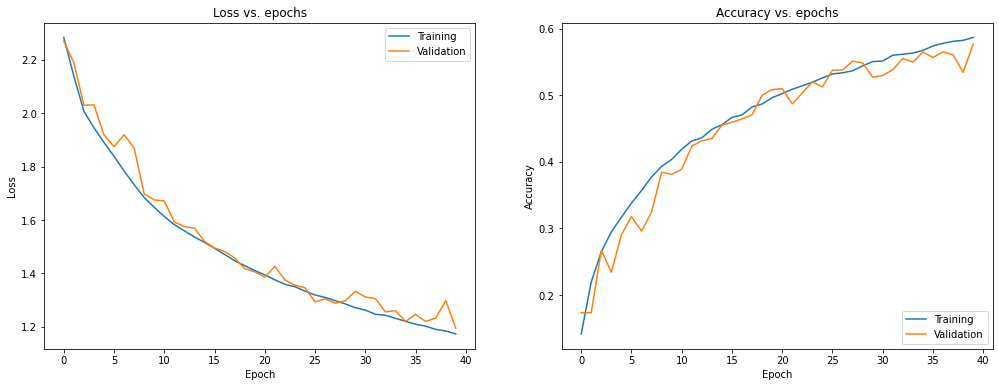

In [23]:
fig = plt.figure(figsize=(17, 6))
# loss against number of epochs
fig.add_subplot(121)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
# accuracy against number of epochs
fig.add_subplot(122)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Dropout appears to be performing slightly worst than the L2-reguraliser in the task above, the L2 regulariser reaches an accuracy of roughly 65% by the 40th epoch whereas Dropout only reaches roughly 59%. Also, the loss with the L2-regulariser is smaller than the loss for the model with Dropout. The converge here also appears to be slower than the model with the L2-regularizer as the loss curve and accuracy curve take longer to flatten. Although implementing Dropout has drastically reduced the generalization gap from the initial model with no regularisers, it underperformed compared to the L2-regulariser. 

#### Early Stopping
We now move onto implementing the last CNN model with another regularisation method. I have chosen to use early stopping. Early stopping cuts the training off before any significant overfitting can take place. I set the patience equal to 15, this corresponds to the number of epochs that the performance is allowed to not improve on the best performnce before the training has terminated.

In [ ]:
# recall model from tast 1.2.1
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # conv layer 1
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'), # conv layer 2
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'), # conv layer 3
    Flatten(),
    Dense(64, activation='relu'),   # fully connected layer
    Dense(10, activation='softmax') # output layer
    ])

# compile the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.1) # optimizer
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [31]:
# Train the model, using early stopping
from tensorflow.keras.callbacks import EarlyStopping

def earlystopping_model(model):
    early_stopping = EarlyStopping(patience=15, monitor='val_accuracy')
    history = model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), 
                        validation_batch_size=128, callbacks=[early_stopping], verbose=False)
    return history

history_3 = earlystopping_model(model)

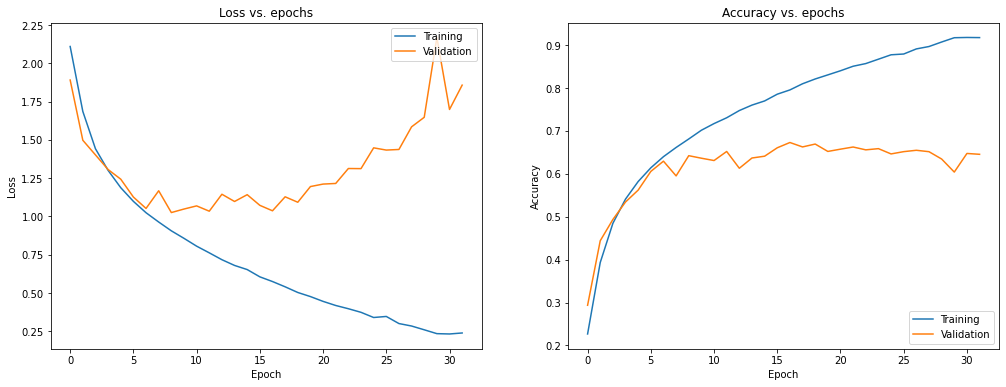

In [32]:
fig = plt.figure(figsize=(17, 6))
# loss against number of epochs
fig.add_subplot(121)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
# accuracy against number of epochs
fig.add_subplot(122)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

From the graphs, we can see the training terminated after epoch 31, however there is still a very large generalization gap and not much improvement from the model in task 1.2.1. I therefore try reducing the patience to see whether we get better results.

In [35]:
# recall model from tast 1.2.1
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # conv layer 1
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'), # conv layer 2
    MaxPooling2D((2,2)),
    Conv2D(64, (3, 3), activation='relu'), # conv layer 3
    Flatten(),
    Dense(64, activation='relu'),   # fully connected layer
    Dense(10, activation='softmax') # output layer
    ])

# compile the model
sgd = tf.keras.optimizers.SGD(learning_rate=0.1) # optimizer
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [36]:
# Train the model, using early stopping
from tensorflow.keras.callbacks import EarlyStopping

def earlystopping_model(model):
    early_stopping = EarlyStopping(patience=5, monitor='val_accuracy')
    history = model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), 
                        validation_batch_size=128, callbacks=[early_stopping], verbose=False)
    return history

history_3 = earlystopping_model(model)

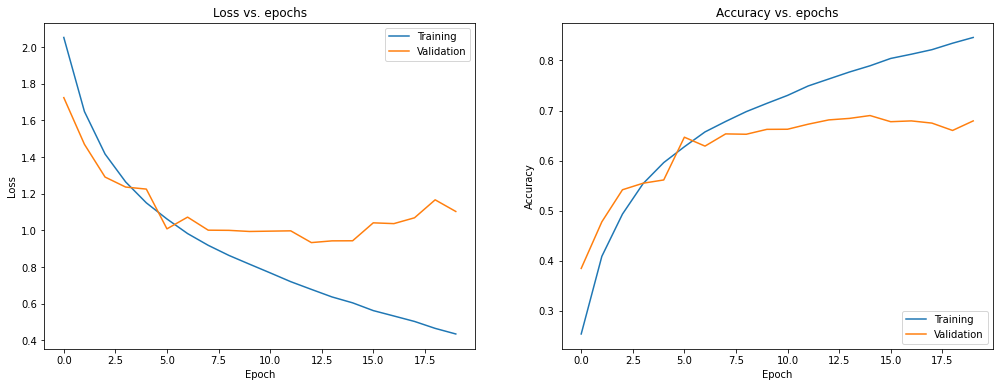

In [37]:
fig = plt.figure(figsize=(17, 6))
# loss against number of epochs
fig.add_subplot(121)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
# accuracy against number of epochs
fig.add_subplot(122)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

Indeed, with a patience of 5, the model stops training after 18 epochs and we indeed get a reduced generalisation gap. However, this model performs much worst than the model with L2 regularisation above. We can therefore conclude that Dropout and L2 regularisation were the best regularisers for this model.

#### 1.2.4
Compare the results obtained with the MLP in 1.1.1 to the results obtained with the CNN in 1.2.3
with Dropout in terms of accuracy, computational time for training over the same number of epochs, and
number of parameters in the models. Explain the observed differences.

In [38]:
# train the CNN model with Dropout and time it
import timeit
start_time = timeit.default_timer()
history_2 = dropout_model.fit(x_train, y_train, epochs=40, batch_size=128, validation_data=(x_val, y_val), validation_batch_size=128, verbose=False) 
end_time = timeit.default_timer()
elapsed_time = end_time - start_time
print ("Time elapsed for training CNN with Dropout:", elapsed_time)

Time elapsed for training CNN with Dropout: 137.477765309


There is an extra parameter in the CNN model with Dropout as we have the dropout rate.
Also, for the CNN model in 1.2.3, we got to use in-buily neural network functions in Python which made computational time much quicker than for the MLP model in 1.1.1

In task 1.1.1, we are training the MLP with a learning rate of 0.01 however, in 1.2.3, when we implement CNN with Dropout, we are using a learning rate of 0.1. I do believe this creates differences: with a high learning rate, you are likely to miss out on the optimal solution, however, with a smaller learning rate, there is a larger computational time. There is a trade off between the two. This is another point as to why the training time with CNN is lower (it had a smaller learning rate).

In terms of training time, training CNN with Dropout takes about 137.5 seconds.

## Task 2: Unsupervised learning
In this task, we will work with a dataset associated with Zachary's karate club. This is a classic small dataset in social science describing a karate club that eventually split acrimoniously into two separate groups.
### 2.1 Clustering of the feature matrix
### 2.1.1 K-means

In this first part, we aim to obtain optimised clusterings by running k-means from $100$ random initialisations for all values of $k$ in the interval $[2, 10]$ and to plot the average within-cluster distance as a function of $k$. 

K-means is an unsupervised machine learning technique that aims at grouping oberservations into clusters. The clusters are formed by minimizing the sum of the distance of points from their respective cluster centroids. It is a clustering problem that follows this algorithm:
1. Given a number of clusters $k$, assign every sample to one of the $k$ clusters at random.
2. Compute the centroid of each of the $k$ clusters:
$$
\textbf{m}_l=\frac{1}{|c_l|}\sum_{i \in c_l}\textbf{x}^{(i)},     l=1,...,k
$$
3. Reassign each $\textbf{x}^{(i)}$ to the closest centroid. Mathematically speaking, we consider the cluster assigned to $\textbf{x}^{(i)}$ at iteration $t$, which is denoted by $l_i^{(t)}$, and evaluate the following:
$$
l_i^{(t+1)}=argmin_l||\textbf{x}^{(i)} - \textbf{m}_l||^2
$$
4. Iterate steps 1 and 2 until convergence, i.e. $W(C)$ does not improve much or the assignments do not change.


Before we begin, we start with a bit of **Explanatory Data Analysis** to see what our data looks like. The feature matrix is a 34 x 100 matrix that corresponds to a set of features characterising the personality profile of all the individuals. There are $N=34$ samples/indivuduals and $p=100$ features capturing different traits.

In [39]:
from google.colab import files

feature_matrix = files.upload()
feature_matrix = pd.read_csv('feature_matrix_karate_club.csv')
feature_matrix.head()

Saving feature_matrix_karate_club.csv to feature_matrix_karate_club.csv


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0,0.148640,-0.187110,-0.109395,0.111767,-0.024913,-0.117825,-0.072237,0.109746,-0.088250,0.210684,0.150548,0.073093,0.123050,0.013435,0.030419,-0.054971,-0.024773,0.027176,-0.031192,0.244318,-0.023978,0.063524,-0.017616,0.015206,0.021023,-0.166403,-0.054085,-0.107196,0.001245,0.007582,0.289484,0.270203,0.006445,-0.020518,-0.012005,-0.051826,-0.020969,0.011466,-0.056162,...,0.028428,-0.008585,-0.005356,0.004676,-0.080010,-0.009942,0.031553,-0.004652,0.253691,-0.204913,-0.136118,-0.030316,-0.096400,0.225578,-0.015016,0.187137,-0.033505,0.105795,0.081647,0.109687,-0.209020,0.059035,-0.163512,0.148144,0.081538,0.067741,-0.062299,0.085511,-0.025227,-0.000347,-0.189510,0.159313,-0.049753,-0.087644,0.000696,-0.175261,0.022859,0.021394,-0.021918,0.091434
1,1,0.207001,-0.018979,-0.094483,0.013424,-0.106083,0.252485,0.092830,0.002718,0.224389,0.061539,-0.011964,-0.124062,0.363754,-0.186012,0.005853,0.154634,-0.007437,-0.056847,-0.153121,0.155806,0.005505,-0.009769,0.129684,-0.140923,0.107991,-0.089491,-0.159392,-0.118141,-0.028254,0.036730,-0.002560,0.157207,0.197316,0.006478,0.102904,-0.030648,0.069637,-0.046797,0.140729,...,0.062679,0.014824,-0.128387,-0.134759,0.062570,-0.029479,0.179281,0.067871,-0.068197,-0.114838,0.064042,-0.100662,0.077444,0.063021,-0.264820,0.064246,0.116419,0.249359,-0.052354,0.072864,-0.106953,0.066344,-0.123868,0.062012,-0.137671,0.238824,0.214205,-0.024426,0.005841,-0.018725,-0.038627,-0.046464,0.135634,0.019332,-0.020542,0.110290,0.060942,-0.034289,-0.145765,-0.025004
2,2,0.093962,-0.262451,-0.033010,0.108551,0.008679,-0.077413,0.051345,0.082396,-0.020187,0.186536,0.089231,0.135319,0.090328,0.024973,-0.015908,-0.023561,-0.014670,0.080317,-0.047213,0.214932,-0.047513,-0.026536,-0.035187,-0.097793,0.019769,-0.127663,-0.161302,-0.109478,-0.059508,0.010361,0.360806,0.188856,-0.036842,-0.074423,-0.114003,-0.101569,0.045303,-0.094968,-0.057626,...,0.090830,0.063318,0.091495,-0.040649,-0.023695,-0.059613,-0.054952,0.023410,0.231272,-0.190606,-0.137444,0.004251,-0.003580,0.260090,-0.048785,0.165900,-0.032723,0.044123,0.105217,0.039117,-0.123564,-0.058834,-0.228224,0.168047,0.050522,0.122184,0.025836,0.087772,-0.116110,-0.014269,-0.104434,0.063065,-0.035935,-0.095608,-0.009888,-0.260271,0.116320,-0.085451,-0.024174,0.168612
3,3,0.212280,-0.047187,-0.116486,-0.004627,0.025335,0.020590,-0.123587,0.059001,-0.034748,0.131113,0.042459,0.030327,0.337262,0.129351,0.088097,0.101446,-0.071444,-0.023532,0.071519,0.065602,0.054506,-0.076591,0.160769,-0.068860,0.166010,-0.108786,-0.107945,0.052027,0.183210,0.167495,0.200569,0.125261,0.073310,0.078211,-0.220083,0.012016,0.102766,-0.004946,0.043808,...,0.048102,-0.031842,-0.105416,-0.035706,-0.040562,-0.008207,0.046938,0.050816,0.244273,-0.237922,0.031704,0.130088,0.030010,0.212676,-0.172311,-0.004937,-0.043786,0.139731,0.028731,0.124351,-0.156812,0.045860,-0.050537,0.176160,0.052502,0.014348,-0.068819,0.032854,-0.081729,-0.168563,-0.131347,0.118707,0.089684,-0.110882,0.068188,0.021066,-0.083530,0.100259,-0.105780,-0.012349
4,4,0.053653,0.122337,-0.135267,-0.017862,-0.012216,0.064982,-0.053867,0.120750,-0.060154,0.204295,-0.206539,-0.015263,0.217170,-0.148366,0.180569,0.013032,0.105246,-0.148139,-0.116360,0.170930,-0.001771,0.112156,0.231537,-0.041038,0.044176,0.008420,-0.040560,-0.250178,0.083283,0.061619,0.048926,0.202578,0.204366,0.039983,0.087105,-0.089234,-0.004173,-0.022616,0.069619,...,0.195901,-0.030977,-0.216164,0.030110,0.023235,0.018448,0.278946,0.187778,0.090445,-0.226228,-0.057770,0.058457,0.085250,0.099034,-0.171122,0.055066,0.107468,0.286436,-0.016551,0.182212,-0.139626,0.105842,-0.154053,0.130488,0.012465,0.116014,0.034504,0.004923,-0.015391,-0.044740,-0.159809,0.032044,0.096484,-0.012787,0.056482,0.172031,-0.167097,0.17673

In [40]:
# turning dataframe into numpy array
feature_matrix = np.array(feature_matrix) 
# removing the first column of the feature matrix
feature_matrix = np.delete(feature_matrix, obj=0, axis=1) 

We start by randomly assigning the "labels" such that a given group of data points belong to one cluster, and computing the centroids of these clusters. This is done in the first function "kmeans_centroids".
A problem I faced here was that I was getting errors when not all labels were used. This is why I made sure each label was used at least once by creating an array with all numbers from 0 to k and then randomly assigning the rest of the labels.

In [41]:
def kmeans_centroids(X, k, i):
    n_samples, n_features = X.shape
 
    # labels: assign every sample to a cluster at random
    np.random.seed(i)
    # making sure each label is used
    labels = np.concatenate((np.array([i for i in range(k)]), np.random.randint(low=0, high=k, size=n_samples-k)))         
    np.random.shuffle(labels)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]  
    
    return centroids, labels

Secondly, in the kmeans algorithm, I now had to deal with the problem of empty clusters. If any of the clusters has no data points associated with it, I replaced it with a random data point and carried on with the algorithm.

In [42]:
def kmeans(X, centroids, labels, k, max_iter=20):
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            labels = new_labels
            for c in range(k):
                if len(X[labels==c])>0:
                    # update centroids by taking the mean over associated data points
                    centroids[c] = np.mean(X[labels==c], axis=0) 
                else: 
                    # dealing with empty cluster
                    centroids[c] = X[np.random.randint(low=0, high=len(X), size=1)]
    return centroids, labels     

The within-cluster distance that we seek to plot against $k$ is given as follows:
$$
W = \sum_{l=1}^k\sum_{i \in c_l} ||\textbf{x}^{(i)} - \textbf{m}_l||^2
$$
Where $k$ is the number of clusters, $\textbf{m}_l$ is the centroid for cluster $l$.

The following function calculate this value.

In [44]:
def within_distance(centroids, labels, X, k):
    W = 0
    for i in range(k):
        index = np.squeeze(np.argwhere(labels==i)) # finding indeces of points in a cluster
        W += (np.linalg.norm(X[index,:]-centroids[i,:]))**2
    return W

This following funtion runs k-means for 100 random initialisations for a given value of $k$.

In [45]:
def iterations(k, X):
    wc_distance_k = []
    for i in range(101):
        centroids, labels = kmeans_centroids(X, k, i)
        centroids, labels = kmeans(X, centroids, labels, k, max_iter=20)
        w = within_distance(centroids, labels, X, k)
        wc_distance_k = np.append(wc_distance_k, w)
    return np.mean(wc_distance_k)

And lastly, we loop over all value of k in the range $[2, 10]$ and plot the average within-cluster distance as a function of $k$.

In [46]:
X = feature_matrix
average_dists = []
for k in range(2,11):
    a = iterations(k, X)
    average_dists = np.append(average_dists, a)

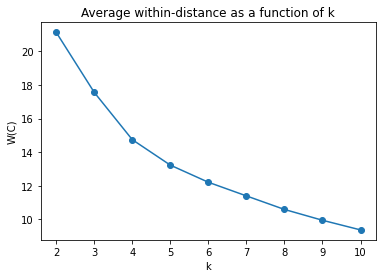

In [47]:
k = range(2,11)
plt.plot(k, average_dists, '-o')
plt.title("Average within-distance as a function of k")
plt.xlabel("k")
plt.ylabel("W(C)")
plt.show()

From the plot above, we can see that as the number of clusters $k$, increases, the within-distance decreases. This goes with my intuition that as you increase the number of clusters, the clusters become smaller hence the distance between the centroid of that cluster and the data points in that cluster decreases. The "elbow" shape curve can be used to determine the optimal number of clusters $k$. I think on the graph above it is actually quite difficult to identify the optimal point as there is no sharp "elbow" shape. However, we can see the drop in the within-cluster distance starts to slow down after $k=4$. Therefore, $4$ is the optimal number of clusters according to this plot.

There are several other measures that can help us identify the optimal number of clusters. This includes the CH-score that we will explore in the next task.

### 2.1.2 Calinski-Harabasz (CH) score to find optimal clustering

The CH score is used to measure the validity of clustering when there is no ground truth available. It is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. In an equation, we get:
$$
C_k = \frac{B(k)}{W(k)}\frac{N-k}{k-1}
$$
where $B(k)=\sum_{i=1}^kn_i||m_i-m||^2$ and $W(k)$ is the within-cluster distance as defined in the task above. $k$ is the number of clusters, $N$ is the number of observations, $n_i$ is the number of observations under cluster $i$, $m_i$ is the centroid of cluster $i$ and $m$ is the mean of the sample data. 
The best clustering will have a small within-cluster distance and large between-cluster distance, therefore, the optimal number of clusters will come from the largest CH score. (2)

I first define a function that calculates the between-cluster distance $B(k)$.

In [51]:
def between_distance(X, k, centroids, labels):    
    bc_distance = 0
    for i in range(k):
        len_cluster_k = sum(labels == i)
        mean = np.mean(X, axis=0)
        bc_distance += len_cluster_k*np.linalg.norm(centroids[i]-mean)**2
    return bc_distance     

In [48]:
# function that computes CH score
def ch_score(X, k, centroids, labels):
    n_samples, _ = X.shape
    bc_distance = between_distance(X, k, centroids, labels)
    wc_distance = within_distance(centroids, labels, X, k)
    ch_score = (bc_distance * (n_samples - k)) / ((wc_distance * (k - 1.)))
    return ch_score

Similarly to the task above, I will do 100 random initialisations for all values of k in the interval $[2, 10]$.

In [49]:
# measuring CH score after 100 random initialisations for a chosen k
def CH_iterations(k, X):
    CH_score_k = []
    for i in range(101):
        centroids, labels = kmeans_centroids(X, k, i)
        centroids, labels = kmeans(X, centroids, labels, k, max_iter=20)
        score = ch_score(X, k, centroids, labels)
        CH_score_k = np.append(CH_score_k, score)
    return np.mean(CH_score_k)

In [52]:
# getting the CH score for each value of k over 100 iteration
X = feature_matrix
average_CH = []
for k in range(2,11):
    b = CH_iterations(k, X)
    average_CH  = np.append(average_CH , b)

We now plot the CH score as a function of increasing k and find the optimal clustering according to the CH score.

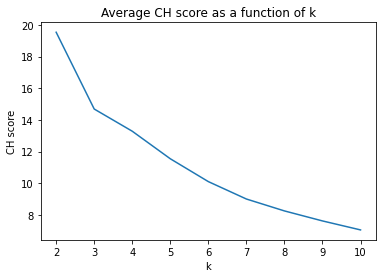

In [53]:
# plotting average CH-score over 100 iterations for different values of k
plt.plot(range(2,11), average_CH)
plt.title("Average CH score as a function of k")
plt.xlabel("k")
plt.ylabel("CH score")
plt.show()

From the graph above, we can clearly see that at $k=2$, the CH-score is the greatest and from literature, we know the higher the CH-score, the better the clustering is. Hence, the optimal number of clusters according to the CH-score is $2$.

However, some other sources pointed out that if the curve is horizontal/ascending/descending like we have, there is no reason to pick one solution over the others. But if there is a peak or an abrupt elbow, we would choose this value of $k$. With this reasoning, it would perhaps be more sensible to pick $k=3$ as the optimal $k$. (3) Therefore, the optimal $k$ according to the CH-score could be either $2$ or $3$. Because of this uncertainty, we could use other clustering measures such as the Sihouette Index to reinforce our justification.

### 2.1.3 Robustness of the clusterings
In this task, we use the different clusterings obtained from the 100 random initialisations of the k-means algorithm
in task 2.1.1 to evaluate the robustness of the clusterings as a function of $k$. We explore this with different measures that capture the consistency and variability of the clusterings obtained as a function of $k$.

Variability comes in 2 different kinds:
1. Variability in the losses from the 100 initialisations. 
2. Variabilty in the actual clusters themselves.

1 is essentially the variability in the cost function and for this, we take the variance of the losses (within-cluster distace).

In [55]:
# getting the within cluster distances from the 100 initialisations
def iterations_2(k, X):
    wc_distance_k = []
    for i in range(101):
        centroids, labels = kmeans_centroids(X, k, i)
        centroids, labels = kmeans(X, centroids, labels, k, max_iter=20)
        w = within_distance(centroids, labels, X, k)
        wc_distance_k = np.append(wc_distance_k, w)
    return wc_distance_k

In [56]:
# obtain the variance of the losses
var_losses = []
for k in range(2, 11):
  wc_distance_k = iterations_2(k, feature_matrix)
  var_loss = np.var(wc_distance_k)
  var_losses = np.append(var_losses, var_loss)

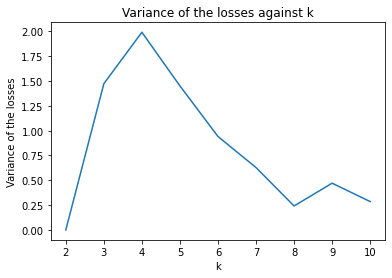

In [57]:
# plotting variance of the losses
plt.plot(range(2,11), var_losses)
plt.ylabel("Variance of the losses")
plt.xlabel("k")
plt.title("Variance of the losses against k")
plt.show()

For the second source of variabilty, essentially the variability of the solution. Since we are given the ground truth labels, we can use a metric to evaluate the labels, for examples the Adjusted Rand Index (ARI). The ARI uses true cluster assignments to measure the similarity between true and predicted labels. This will enable us to see how good our solution is. I do not go into much detail about the ARI here as we will later be exploring it in more depth. Essentially, the closer the ARI is to 1, better the clustering will be.

In the ground truth labels, it appears there are 2 classes. I will be comparing k-means with $k=2$ and $k=3$ to these true labels to justify how variable the solutions are. I first import all the data and set up the function for ARI.

In [75]:
# getting ground truth labels
from google.colab import files

ground_truth = files.upload()
ground_truth = pd.read_csv('ground_truth_karate_club.csv')

#turning dataframe into numpy array
ground_truth = np.array(ground_truth) 
# removing the first column of the ground_truth data
ground_truth = np.delete(ground_truth, obj=0, axis=1) 

# replace the labels with 0s with 1s
ground_truth = np.where(ground_truth == "Mr. Hi", 0, ground_truth) 
ground_truth = np.where(ground_truth == "Officer", 1, ground_truth)

ground_truth = np.array([i[0] for i in ground_truth])

Saving ground_truth_karate_club.csv to ground_truth_karate_club (1).csv


In [76]:
# create combinatorial function
from math import factorial
def choose(x, n=2):
    if x > n:
        top = factorial(x)
        bottom = n*factorial(x-n)
        return top/bottom
    else: # ensuring that denominator is not 0
        return 0.

In [77]:
# function that computes the different components of the ARI
def components(labels_true, labels_pred):
    cont_table = pd.crosstab(labels_true, labels_pred)
    rows, columns = cont_table.shape
    row_sum = np.sum(cont_table, axis=1)
    column_sum = np.sum(cont_table, axis=0)
    a_i = 0
    b_j = 0
    n_ij = 0
    for i in range(rows): 
        a_i += choose(row_sum[i] , n=2) # a_i is the row sum
    for j in range(columns): 
        b_j += choose(column_sum[j] , n=2) # b_j is the column sum
    for i in range(columns):
        for j in range(rows): 
            n_ij += choose(cont_table[i][j] , n=2)
    N = choose(len(labels_true), n=2) 
    e = a_i*b_j/N       
    return a_i, b_j, n_ij, e

In [78]:
# putting everything together to compute ARI
def ARI(labels_true, labels_pred):
    a_i, b_j, n_ij, e = components(labels_true, labels_pred)
    ari = (n_ij - e) / ((a_i+b_j)/2 - e)
    return ari

I try both with $k=2$ and $k=3$. Firstly, with $k=2$.

In [79]:
# getting the predicted labels from kmeans with the optimal number of clusters 
X = feature_matrix
k = 2
i = 8 # pick a random seed
centroids, labels = kmeans_centroids(X, k, i)
centroids, labels = kmeans(X, centroids, labels, k, max_iter=20)
labels_pred_kmeans_2 = labels
print("The ARI for k-means and ground truth is ", ARI(ground_truth, labels_pred_kmeans_2))

The ARI for k-means and ground truth is  0.0012970168612192327


Repeat with $k=3$.

In [80]:
# getting the predicted labels from kmeans with the optimal number of clusters 
X = feature_matrix
k = 3
i = 8 # pick a random seed
centroids, labels = kmeans_centroids(X, k, i)
centroids, labels = kmeans(X, centroids, labels, k, max_iter=20)
labels_pred_kmeans_3 = labels
print("The ARI for k-means and ground truth is ", ARI(ground_truth, labels_pred_kmeans_3))

The ARI for k-means and ground truth is  0.05899705014749266


From the ARI it appears that kmeans with $k=3$ performs better than kmeans with $k=2$.

### 2.2 Dimensionality reduction of the feature matrix

### 2.2.1 Principle Component Analysis

In this task, we plot the $N=34$ samples of the dataset as points in the d-dimensional PCA space for dimensions: 1) $d=1$, 2) $d=2$, and 3) $d=3$

Principal Component Analysis (PCA) is a dimensionality reduction technique that follows the 3 following steps:
1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.

In [ ]:
def normalize(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

In [ ]:
feature_matrix = normalize(feature_matrix)

In [ ]:
from scipy.sparse import linalg

def pca_function(X,k):

  # create covariance matrix
  C = 1.0/(len(X)-1) * np.dot(X.T, X)

  # compute eigenvalues and eigenvectors using the eigsh scipy function
  eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

  # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
  sorted_index = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[sorted_index]
  eigenvectors = eigenvectors[:,sorted_index ]

  # transform our data
  X_pca = X.dot(eigenvectors)

  return X_pca, eigenvectors, eigenvalues

**1)** We begin with the 1-dimensional principle component plot.

In [ ]:
# choose our number of principle components
k = 1

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(feature_matrix,k) 

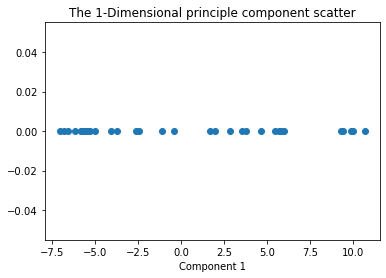

In [ ]:
plt.scatter(X_pca[:,0],np.zeros(34))
plt.title("The 1-Dimensional principle component scatter")
plt.xlabel("Component 1")
plt.show()

**2)** Now we set the number of dimensions to be 2.

In [ ]:
# choose our number of principle components
k = 2

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(feature_matrix,k) 

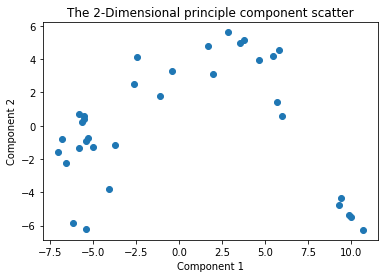

In [ ]:
plt.scatter(X_pca[:,0],X_pca[:,1])
plt.title("The 2-Dimensional principle component scatter")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

**3)** And lastly, for $d=3$.

In [ ]:
# choose our number of principle components
k = 3

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(feature_matrix,k) 

Text(0.5, 0, 'Component 3')

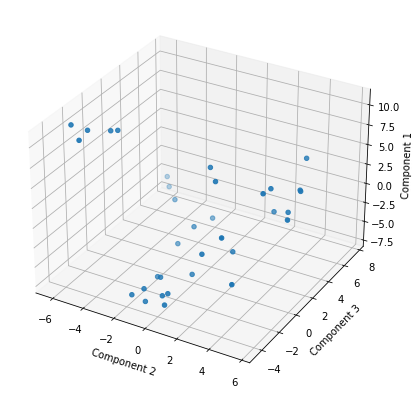

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

# data for a three-dimensional plot
zdata = X_pca[:,0]
xdata = X_pca[:,1]
ydata = X_pca[:,2]

# plotting
ax.scatter3D(xdata, ydata, zdata)
ax.set_zlabel("Component 1")
ax.set_xlabel("Component 2")
ax.set_ylabel("Component 3")

PCA can be used both for dimensionality reduction and for clustering. You could base a k-means clustering on PCA. And as we know, PCA is based on the eigenvectors of the $F^TF$ matrix which is giving you a reduced dimensional description of the data. By examining the structure in those eigenvectors, we should be able to see that there is a correspondance with the groups we obtain in task $2.1$. Indeed, the data looks like they are split into 2-3 clusters, like we got from the CH-score.

### 2.2.2 Proportion of explained variance PCA
In this task, we will plot the proportion of explained variance of the PCA approximations of reduced dimensionality $d$ for all values of d in the interval $[1, 10]$. 

The proportion of explained variance of a principal component is defined as the ratio between the variance of that principal component and the total variance explained by all components. To obtain the 10 eigenvalues of the 10 principal components, I simply compute PCA for $d=10$.

In [ ]:
# choose our number of principle components
k = 10

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(feature_matrix,k) 
explained_variances = eigenvalues / np.sum(eigenvalues)

print('The proportion of explained variance for the first 10 principle components is: \n', explained_variances)

The proportion of explained variance for the first 10 principle components is: 
 [0.40823444 0.15642846 0.1260114  0.06814787 0.05808377 0.04625379
 0.03804753 0.0348847  0.03345459 0.03045345]


Text(0.5, 1.0, '% Explained variance as number of components increases')

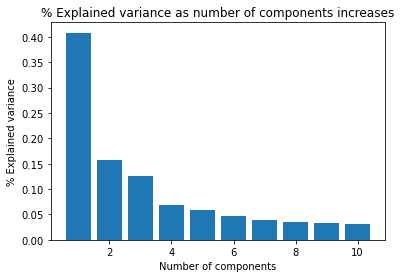

In [ ]:
plt.bar(range(1,11), explained_variances)
plt.xlabel("Number of components")
plt.ylabel("% Explained variance")
plt.title("% Explained variance as number of components increases")

About 69% of the variance is explained by the first 3 components, this is an indication that the dataset is well described in a reduced dimension. PCA is based on the eigenvector of the $F^TF$ matrix which is giving you a reduced dimensional description of the data. The subspace spanned by the principal component direction is identical to the cluster centroid subspace.

### 2.3 Graph-based analysis
### 2.3.1 Centralities

To begin, graph centralities allow us to give a measure of importance of different nodes (or edges) in the graph. There are different measures one can use to do this and we will explore 3 of these in this task - PageRank, degree centrality, and eigenvector centrality (I will be using the definitions from our lecture notes). We will then study which nodes are highly central according to the three centralities (I will be looking at the top 8 central nodes as these will be used in the following task). Lastly, we will discuss the similarity between the node rankings according to the different centrality measures and explain why the centrality rankings might differ.

PageRank and eigenvector centrality are spectral measures of centrality. As opposed to these two, degree centrality is a combinatorial measure (counting the number of number of connections).

Similarly, we start off with a bit for EDA to see what the adjacency matrix A looks like.

In [ ]:
# import data
#from google.colab import files

#karate_graph = files.upload()
karate_graph = pd.read_csv('karate_club_graph.csv')
karate_graph.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#turning dataframe into numpy array
karate_graph = np.array(karate_graph) 
# removing the first column of the karate_graph data
A = np.delete(karate_graph , obj=0, axis=1)

We also visualise the adjacenty matrix.

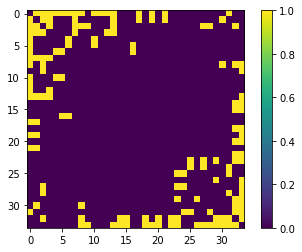

In [ ]:
# plot a heatmap of the adjacency matrix
plt.imshow(A)
plt.colorbar()

**1) PageRank**

PageRank is probably the most important centrality measure. To model this, we model a random walk on a graph where we have a probability that we follow the directed graph given and the rest of the probability will be to jump to another node with no connection to the node at which you are - $\alpha$ is the probability that we follow the random walk along the directed graph, and jump with prob $1-\alpha$ to any other node on the graph. PageRank is the stationary point of this process. It is an iterative process defined by:
$$
\textbf{c}_{PR_{t+1}}= \alpha(AD^{-1})\textbf{c}_{PR_t} + (1-\alpha)\frac{\textbf{1}}{N}
$$
Our goal is therefore to solve the following equation:
$$
\textbf{c}_{PR}= \alpha(AD^{-1})\textbf{c}_{PR} + (1-\alpha)\frac{\textbf{1}}{N}
$$
Where $N$ is the number of nodes and $AD^{-1}$ is the transition matrix (making every column sum to 1). The default value we set for alpha is 0.85.

In [ ]:
def page_rank(A, alpha=0.85, tol=1e-2, max_iter=100):
  transition_matrix = A / A.sum(axis=0)
  N = len(A)
  pr = np.ones(N) * 1./N
  for it in range(max_iter):
        old_pr = pr
        pr = alpha * transition_matrix.dot(pr) + (1-alpha)/N 
        err = np.absolute(pr - old_pr).sum()
        if err < tol:
            return pr

In [ ]:
pagerank = page_rank(A, alpha=0.85, tol=1e-4, max_iter=100)
print("PageRank of the graph: \n", pagerank)

PageRank of the graph: 
 [0.09700637 0.05287998 0.05707835 0.03586122 0.02198064 0.02911521
 0.02911521 0.02449071 0.02976443 0.0143084  0.02198064 0.00956498
 0.01464531 0.02953579 0.01453417 0.01453417 0.01678665 0.01455882
 0.01453417 0.01960389 0.01453417 0.01455882 0.01453417 0.03151937
 0.0210751  0.02100533 0.01504278 0.02563788 0.01957248 0.02628607
 0.02458832 0.037155   0.07169261 0.10091876]


In [ ]:
# top 8 most central nodes for PageRank
top_pagerank_nodes = np.argsort(pagerank)[-8:]
print("The top 8 most central nodes according to degree centrality are nodes", top_pagerank_nodes)

The top 8 most central nodes according to degree centrality are nodes [23  3 31  1  2 32  0 33]


Where node $33$ is the most central node and node $23$ is the 8th most central node.

**2) Degree centrality**

Degree centrality is the simplest measure of centrality and the importance of a node is simply defined by its degree. The degree centrality of a node is the fraction of nodes it is connected to. This measure is directly computed from the adjacency matrix $A$. Note that several equivalent equations exist for degree centrality, I have chosen the following one:
$$
\textbf{c}_d = \frac{\textbf{d}}{2E} = \frac{A\textbf{1}}{2E}
$$
where $A$ is the adjency matrix and $E$ is the number of edges in the graph, in our case $E=78$.

In [ ]:
def degree_centrality(A):
  sum_of_rows = np.sum(A, axis=1)
  degree_centrality = sum_of_rows / (2*78)
  return  degree_centrality

In [ ]:
degreecentrality = degree_centrality(A)
print("Degree Centralities of the graph: \n", degreecentrality)

Degree Centralities of the graph: 
 [0.1025641  0.05769231 0.06410256 0.03846154 0.01923077 0.02564103
 0.02564103 0.02564103 0.03205128 0.01282051 0.01923077 0.00641026
 0.01282051 0.03205128 0.01282051 0.01282051 0.01282051 0.01282051
 0.01282051 0.01923077 0.01282051 0.01282051 0.01282051 0.03205128
 0.01923077 0.01923077 0.01282051 0.02564103 0.01923077 0.02564103
 0.02564103 0.03846154 0.07692308 0.10897436]


In [ ]:
# top 8 most central nodes for degree centrality
top_degree_nodes = np.argsort(degreecentrality)[-8:]
print("The top 8 most central nodes according to degree centrality are nodes", top_degree_nodes)

The top 8 most central nodes according to degree centrality are nodes [23  3 31  1  2 32  0 33]


According to degree centrality, the top 8 nodes are the same as those of PageRank.

**3) Eigenvector centrality**

Lastly, the idea behind this measure is that the central node is connected to other central nodes, i.e. the eigenvector centrality centrality of node i can be thought of as a linear combination of eigenvector centrality of node j:
$$
\textbf{c}_e(i) = \alpha \sum_j A_{ij}\textbf{c}_e(j)
$$
We can rewrite this as a matrix-eigenvalue problem given by:
$$
A\textbf{c}_e = \lambda \textbf{c}_e
$$
This can be solved by looking at the leading eigenvector of the adjacency matrix $A$. The leading eigenvector of $A$ has as its components the eigenvector centralities of each of the nodes.

In [ ]:
import scipy.linalg as la

def eigenvector_centrality(A):
  matrix_size = len(A)
  # get eigenvalues and eigenvectors
  eigvals, eigvecs = la.eig(A)
  # index of the max absolute eigenvalue of the graph
  index = (np.abs(max(eigvals, key=abs))).argmax()
  # respective eigenvector of the max eigenvalue
  eigen_centrality_values = [eigvecs[ecv,index] for ecv in range(matrix_size)]
  eigen_centrality_values = np.asarray(eigen_centrality_values) # turning list into a numpy array
  return eigen_centrality_values

In [ ]:
eigenvectorcentrality = eigenvector_centrality(A)
print("Eigenvector Centralities of the Graph: \n", eigenvectorcentrality)

Eigenvector Centralities of the Graph: 
 [0.35549144+0.j 0.26595992+0.j 0.3171925 +0.j 0.21117972+0.j
 0.07596882+0.j 0.07948305+0.j 0.07948305+0.j 0.17095975+0.j
 0.22740391+0.j 0.10267425+0.j 0.07596882+0.j 0.0528557 +0.j
 0.08425463+0.j 0.22647272+0.j 0.10140326+0.j 0.10140326+0.j
 0.02363563+0.j 0.09239954+0.j 0.10140326+0.j 0.14791251+0.j
 0.10140326+0.j 0.09239954+0.j 0.10140326+0.j 0.15011857+0.j
 0.05705244+0.j 0.05920647+0.j 0.07557941+0.j 0.13347715+0.j
 0.13107782+0.j 0.13496082+0.j 0.1747583 +0.j 0.19103384+0.j
 0.30864422+0.j 0.37336347+0.j]


In [ ]:
# top 8 most central nodes for eigenvector centrality
top_eigenvector_nodes = np.argsort(eigenvectorcentrality)[-8:]
print("The top 8 most central nodes according to eigenvector centrality are nodes", top_eigenvector_nodes )

The top 8 most central nodes according to eigenvector centrality are nodes [ 3 13  8  1 32  2  0 33]


Now, we will be exploring the similarity between the node rankings according to the different centrality measures via correlation plots.

The first thing I do is the find the index of the most central node to the least central node. Then, I reindex the nodes such that 0=most central node node and 33=least central node.

In [ ]:
rank = np.argsort(-pagerank) # finding the biggest to smallest node for page rank

# reindexing nodes
rank_p = np.zeros(34)
for i in range(34):
    rank_p[rank[i]] = i

In [ ]:
# do the same for degree centrality
rank = np.argsort(-degreecentrality)
rank_c = np.zeros(34)
for i in range(34):
    rank_c[rank[i]] = i

In [ ]:
# do the same for eigenvector centrality
rank = np.argsort(-eigenvectorcentrality)
rank_e = np.zeros(34)
for i in range(34):
    rank_e[rank[i]] = i

Now we explore the correlation between these.

In [ ]:
# create a dataframe to store ranked centrality measures
df = pd.DataFrame(list(zip(rank_p, rank_c, rank_e)), columns=["PageRank", "Degree Centrality", "Eigenvector Centrality"])
correlation_matrix = df.corr()
correlation_matrix

,PageRank,Degree Centrality,Eigenvector Centrality
PageRank,1.000000,0.963636,0.675783
Degree Centrality,0.963636,1.000000,0.763178
Eigenvector Centrality,0.675783,0.763178,1.000000


Text(0.5, 1.0, 'Correlation plot between node rankings according to different centrality measures')

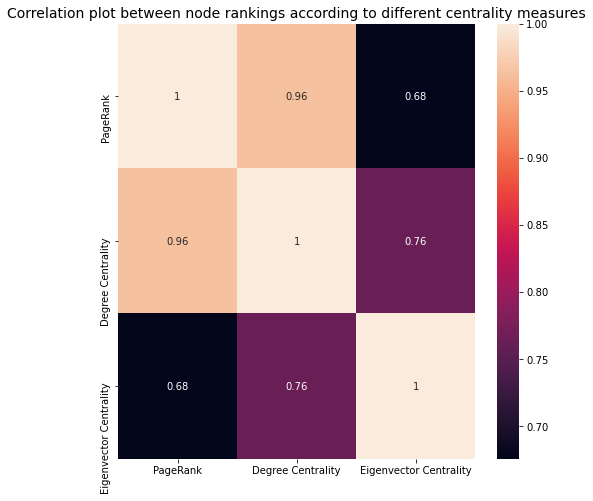

In [ ]:
# plot correlation matrix using heatmap
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.title("Correlation plot between node rankings according to different centrality measures", size=14)

From the correlation plot above, we can observe that degree centrality and PageRank are highly correlated (0.96) centrality measures when the nodes are ranked. As we saw earlier, these two centrality measures had the exact same top 8 most central nodes. Then, degree centrality and eigenvector centrality have a correlation of 0.76 and lastly, PageRank and eigenvector centrality have a correlation of 0.68.

The centrality rankings might differ because PageRank and eigenvector centrality are spectral measures of centrality whereas degree centrality is a combinatorial measure (counting the number of number of connections).

Eigenvector centrality starts of by computing a node's degree, but it goes a step further than degree centrality as it is an iterative process that counts the degree of the connections to that node. It is therefore interesting to note that a node can have a high degree centrality score, but a lower eigenvector centrality score if many of the connections with the node are with other lower-scored nodes. This explains why the correlation between the two is 0.76. (4)

Lastly, a possible reason as to why PageRank is so highly correlated with degree centrality is because the PageRank of an undirected graph is statistically close to the degree distribution of the graph. The PageRank of an undirected graph equals the degree centrality if and only if the graph is regular (every node/vextex has the same degree). (7)

The pairplot below further confirms the strong correlation between PageRank and degree centrality.

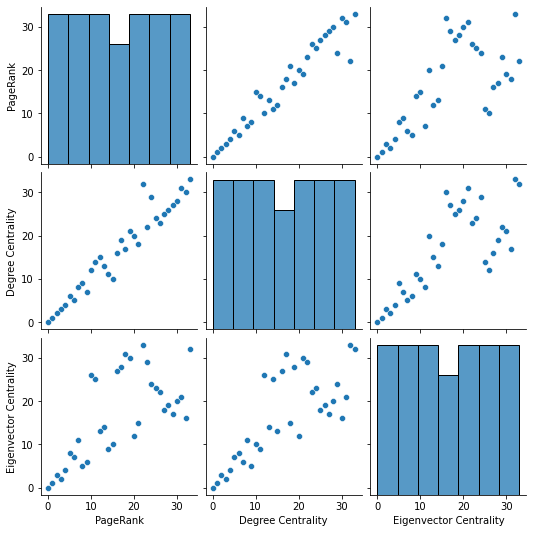

In [ ]:
sns.pairplot(df)

### 2.3.2 Community detection
In this task, we use the Clauset-Newman-Moore greedy modularity maximisation algorithm in NetworkX to compute the optimal number of communities $k^*$ and the corresponding partition of the karate club graph.

In [66]:
import networkx as nx
from google.colab import files

karate_graph = files.upload()
karate_graph = pd.read_csv('karate_club_graph.csv')

#turning dataframe into numpy array
karate_graph = np.array(karate_graph) 
# removing the first column of the karate_graph data
A = np.delete(karate_graph , obj=0, axis=1) # (34, 34)

Saving karate_club_graph.csv to karate_club_graph.csv


In [68]:
# import the Clauset-Newman-Moore greedy modularity maximisation algorithm
from networkx.algorithms.community import greedy_modularity_communities

# creating graph object from adjacency matrix
G = nx.from_numpy_matrix(A)

# finding communities with CNM algorithm
communities = nx.algorithms.community.greedy_modularity_communities(G)

# number of communities
k_star = len(communities)
print("Optimal number of communities: {}".format(k_star))

Optimal number of communities: 3


Next, we find which nodes below to which community.

In [69]:
# find the nodes forming the communities
node_groups = []

for i in communities:
  node_groups.append(list(i))

print("The 3 node groups are: ", node_groups)

The 3 node groups are:  [[32, 33, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], [1, 2, 3, 7, 9, 12, 13, 17, 21], [0, 4, 5, 6, 10, 11, 16, 19]]


Now, we plot the obtained clusters of the graph assigning different colours to the nodes in each community.

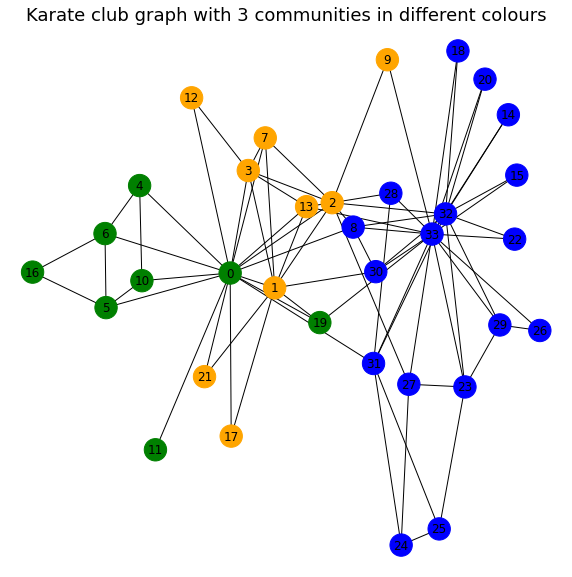

In [ ]:
# plot the communities
colour_map = []
for node in G:
    if node in node_groups[0]:
        colour_map.append('blue')
    elif node in node_groups[1]:
        colour_map.append('orange')
    else: 
        colour_map.append('green')  

plt.subplots(figsize=(10,10))
nx.draw(G, node_color=colour_map, pos=nx.spring_layout(G, iterations=200), with_labels=True, node_size=500)
plt.title('Karate club graph with 3 communities in different colours', fontsize=18)
plt.show()

Next, we show the distribution across the $k^*$ (here 3) communities of the top 8 most central nodes via a histogram according to: 1) degree centrality and 2) Pagerank.

**1) Degree Centrality**

In [ ]:
# top 8 most central nodes for degree centrality
y = degree_centrality(A)
top_degree_nodes = np.argsort(y)[-8:]
print("The top 8 most central nodes according to degree centrality are nodes", top_degree_nodes)

The top 8 most central nodes according to degree centrality are nodes [23  3 31  1  2 32  0 33]


We find the number of central nodes in each community.

In [ ]:
com_1 = 0
com_2 = 0
com_3 = 0

for i in top_degree_nodes:
    if i in node_groups[0]:
        com_1 += 1
    elif i in node_groups[1]:
        com_2 += 1
    else: 
        com_3 += 1
yaxis = [com_1, com_2, com_3]

Text(0.5, 0, 'Community')

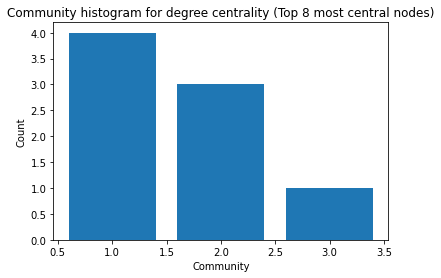

In [ ]:
# plotting histogram to see the distribution of the nodes
plt.bar(range(1,4), yaxis)
plt.title("Community histogram for degree centrality (Top 8 most central nodes)")
plt.ylabel("Count")
plt.xlabel("Community")

**2) PageRank**

We do the same as above for PageRank.

In [ ]:
# top 8 most central nodes for PageRank
z = page_rank(A)
top_pagerank_nodes = np.argsort(z)[-8:]
print("The top 8 most central nodes according to PageRank are nodes", top_pagerank_nodes)

The top 8 most central nodes according to Page rank are nodes [23  3 31  1  2 32  0 33]


In [ ]:
com_1 = 0
com_2 = 0
com_3 = 0

for i in top_pagerank_nodes:
    if i in node_groups[0]:
        com_1 += 1
    elif i in node_groups[1]:
        com_2 += 1
    else: 
        com_3 += 1
zaxis = [com_1, com_2, com_3]

Text(0.5, 0, 'Community')

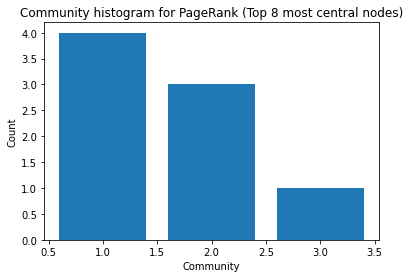

In [ ]:
# plotting histogram to see the distribution of the nodes
plt.bar(range(1,4), zaxis)
plt.title("Community histogram for PageRank (Top 8 most central nodes)")
plt.ylabel("Count")
plt.xlabel("Community")

As we can see from the two histograms, there are 4 nodes in the first community, 3 nodes in the second community and 1 node in the third community for both degree centrality and PageRank. Both histograms are the same because in the previous task, we saw that degree centrality and PageRank were very highly correlated centrality measures. 

Also, the first community contains more of the most central nodes compared to the second and third community. A reason for this is that community 1 has more of the total nodes than the 2 others, meaning that this community is larger with more connections to other central nodes.

### 2.3.3 Comparing clusterings using the Adjusted Rank Index (ARI)

In this task, we will using the ARI to compare how similar the clustering obtained in 2.1.2 is to the one in 2.3.2, as well as how similar those clusterings are to the real-life acrimonious split given in the "ground_truth_karate_club" labels.

The Adjusted Rank Index is use to quantify how similar two clusterings are. It is defined as:
$$
ARI = \frac{RI - Expected RI}{max(RI) - Expected RI} = \frac{\sum_{ij}{n_{ij}\choose 2}-\big[\sum_i{a_{i}\choose 2}\sum_j{b_{j}\choose 2}\big]\big/{N\choose 2}}{\frac{1}{2}\big[\sum_i{a_{i}\choose 2}+\sum_j{b_{j}\choose 2}\big]-\big[\sum_i{a_{i}\choose 2}\sum_j{b_{j}\choose 2}\big]\big/{N\choose 2}}
$$
where $RI$ is the Rand Index, the ARI is the adjusted-for-chance version of the Rand Index (it takes randomness into account).
$N$ is the number of data points in a given data set, $i$  refers to the row number, $j$  refers to the column number, $a_i$ are the row sums of the contingency table, $b_j$ are the column sums of the contingency table and $n_ij are all the elements of the contingency table. (5)

The ARI can take values between $-1$ and $1$. A negative value means that the amount of overlap between the two input clustering sets is less than expected (independent labelling). The closer the ARI as to 1, the more similar the clusterings are.

I first import the ground truth labels from the karate club data and create my ARI function from the definition above.

In [59]:
from google.colab import files

ground_truth = files.upload()
ground_truth = pd.read_csv('ground_truth_karate_club.csv')

#turning dataframe into numpy array
ground_truth = np.array(ground_truth) 
# removing the first column of the ground_truth data
ground_truth = np.delete(ground_truth, obj=0, axis=1) 

# replace the labels with 0s with 1s
ground_truth = np.where(ground_truth == "Mr. Hi", 0, ground_truth) 
ground_truth = np.where(ground_truth == "Officer", 1, ground_truth)

ground_truth = np.array([i[0] for i in ground_truth])

Saving ground_truth_karate_club.csv to ground_truth_karate_club.csv


In [60]:
# create combinatorial function
from math import factorial
def choose(x, n=2):
    if x > n:
        top = factorial(x)
        bottom = n*factorial(x-n)
        return top/bottom
    else: # ensuring that denominator is not 0
        return 0.

In [62]:
# function that computes the different components of the ARI
def components(labels_true, labels_pred):
    cont_table = pd.crosstab(labels_true, labels_pred)
    rows, columns = cont_table.shape
    row_sum = np.sum(cont_table, axis=1)
    column_sum = np.sum(cont_table, axis=0)
    a_i = 0
    b_j = 0
    n_ij = 0
    for i in range(rows): 
        a_i += choose(row_sum[i] , n=2) # a_i is the row sum
    for j in range(columns): 
        b_j += choose(column_sum[j] , n=2) # b_j is the column sum
    for i in range(columns):
        for j in range(rows): 
            n_ij += choose(cont_table[i][j] , n=2)
    N = choose(len(labels_true), n=2) 
    e = a_i*b_j/N       
    return a_i, b_j, n_ij, e

In [63]:
# putting everything together to compute ARI
def ARI(labels_true, labels_pred):
    a_i, b_j, n_ij, e = components(labels_true, labels_pred)
    ari = (n_ij - e) / ((a_i+b_j)/2 - e)
    return ari

First, I compare how similar the clustering obtained in 2.1.2 (k-means) is to the one in 2.3.2 (from the different communities).

In [72]:
# getting the predicted labels from kmeans with the optimal number of clusters
X = feature_matrix
k = 2
i = 8 # pick a random seed
centroids, labels = kmeans_centroids(X, k, i)
centroids, labels = kmeans(X, centroids, labels, k, max_iter=20)
labels_pred_kmeans = labels

In [73]:
# assigning labels to nodes in different communities
nodes = np.arange(34)
for node in nodes:
    if node in node_groups[0]:
        nodes[node] = 0
    elif node in node_groups[1]:
        nodes[node] = 1
    else: 
        nodes[node] = 2 
labels_pred_community = nodes

In [ ]:
print("The ARI for k-means and community clustering is ", ARI(labels_pred_kmeans, labels_pred_community))

The ARI for k-means and community clustering is  -0.031487014479429976


Next, I compare how similar the clustering from communities is to the real-life acrimonious split.

In [ ]:
print("The ARI community clustering and real-life acrimonious data is ", ARI(ground_truth, labels_pred_community))

The ARI community clustering and real-life acrimonious data is  0.5684394071490846


Lastly, I compare how similar the clustering from 2.1.2 (k-means) is to the real-life acrimonious split given in the "ground_truth_karate_club" labels.

In [74]:
print("The ARI for k-means and real-life acrimonious data is ", ARI(ground_truth, labels_pred_kmeans))

The ARI for k-means and real-life acrimonious data is  0.0012970168612192327


As we can see from the ARI obtained above, the partition obtained from our community detection analysis appear to be the best in that the clustering is similar to the ground truth labels of the karate club graph. K-means performs poorly however, the ARI is close to 0 meaning the clustering between kmeans & the real-life acrimonious split and between kmeans & communities partition split is very dismilar.

### References
**(1)** Kumar, Ujjwal. “Impact of Regularization on Deep Neural Networks”. Towards Data Science. 09/07/2020.
https://towardsdatascience.com/impact-of-regularization-on-deep-neural-networks-1306c839d923

**(2)** "Calinski Harabasz Evaluation". MathWorks. https://www.mathworks.com/help/stats/clustering.evaluation.calinskiharabaszevaluation-class.html

**(3)** Cox, Nick."What is an acceptable value of the Calinski & Harabasz (CH) criterion?" Stack Exchange. 15/07/2019. https://stats.stackexchange.com/questions/52838/what-is-an-acceptable-value-of-the-calinski-harabasz-ch-criterion

**(4)** Disney, Andrew. "EigenCentrality & PageRank." Cambridge Intelligence. 14/01/20. 
https://cambridge-intelligence.com/eigencentrality-pagerank/

**(5)** Tang, Dave. "The Adjusted Rand index". Dave Tang's blog. 21/09/17.
https://davetang.org/muse/2017/09/21/adjusted-rand-index/

**(6)** "Softmax classification with cross-entropy".
https://peterroelants.github.io/posts/cross-entropy-softmax/

**(7)** "PageRank". Wikipedia. 20/03/21. https://en.wikipedia.org/wiki/PageRank#Variations